In [7]:
###
#Demo analysis of the clustering package.
#Within the package, the following algorithms have been implemented:
#
#        - Standard K-Means (KM): 
#            Subcase of KKM with a linear kernel.
#        
#        - Kernel k-Means (KKM): 
#            Clusters in feature space.          
#        
#        - Global Kernel k-Means (GKKM): 
#            kKM with a local search to define initial cluster positions.
#            
#        - Global Kernel k-Means with Convex Mixture Models (GKKM-CMM):
#            optimized boosted version of GkKM to reduce complexity.
#            
#        - Adaptive Weights Clustering (AWC): 
#            A type of adaptive nonparametric clustering.	    
#            
#The present demo evaluates the algorithms performance on the
#Shape sets from the Clustering benchmark datasets page:
#    
#        - https://cs.joensuu.fi/sipu/datasets/
#
###

# Author: Francesco Casola <fr.casola@gmail.com>

In [1]:
# adding the folder to the path
import sys
path_pc = r"../"
sys.path.append(path_pc)
# importing personal package
import clustering as cl

In [2]:
# importing pandas and other modules to handle datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
# os functionalities
import os
#evaluate NMI using the definition in the Efimov paper
from sklearn.metrics import normalized_mutual_info_score as NMI

In [15]:
###
#PART I: The Shape Set
#
#n_samples: from 240 to 3100
#n_features: 2
#n_clusters: from 2 to 31
###

In [3]:
#1 - Loading datasets
path = r"../data/Shape_Set"
#dictionary of a set of dataframes
set_dataframes = {}
#gathering and loading fles
for fname in os.listdir(path):
    if fname.endswith('.txt'):
        local_fname = os.path.join(path,fname).replace("\\","/")
        set_dataframes[fname.strip('.txt')] = pd.read_csv(local_fname,delimiter='\t', lineterminator='\n', \
                                           names = ["X", "Y", "Labels"])

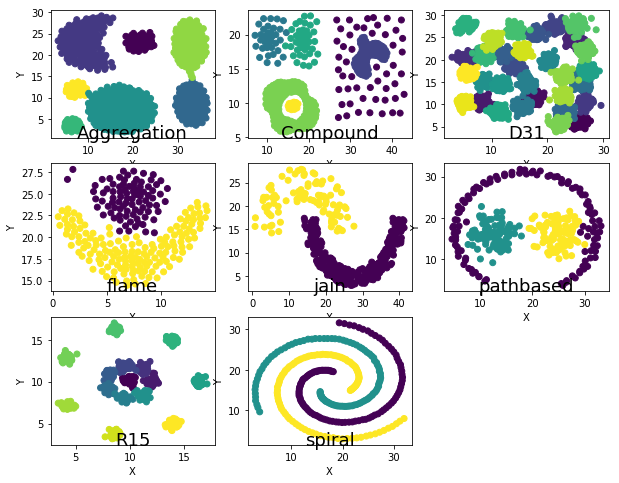

In [4]:
#2a - plotting datasets
#dataset names
dts_names = list(set_dataframes.keys())
#dataset size
dt_size = len(dts_names)
#approximating to nearest bigger square
perf_sq = np.arange(1,100)
id_plots = np.where(perf_sq**2>=dt_size)[0]
n_plots = perf_sq[id_plots[0]]

#making the plot
plt.figure(num=1,figsize=(10,8))
for i in range(1, n_plots**2):
    plt.subplot(n_plots, n_plots, i) 
    ax = plt.scatter(set_dataframes[dts_names[i-1]]["X"], \
                 set_dataframes[dts_names[i-1]]["Y"], \
                 c=set_dataframes[dts_names[i-1]]["Labels"])
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], dts_names[i-1],
             fontsize=18, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")

Finding optimal solution with 2 clusters.
Finding optimal solution with 2 clusters.


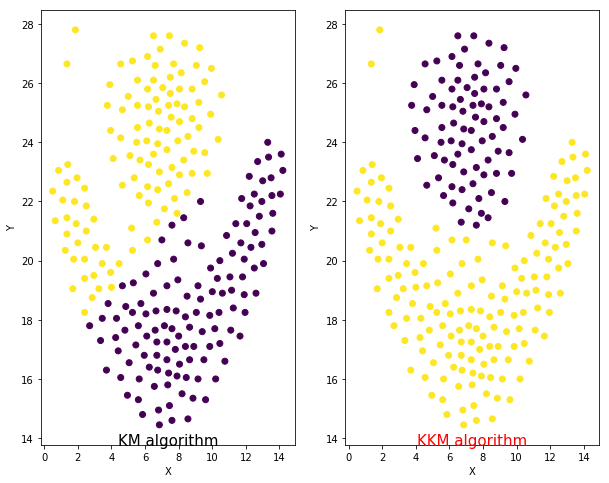

In [17]:
#2b - We make a first comparison between the 2 simplest partitional algorithms: the KM and KKM one.
#We remind the reader that KM is a standard k-means algorithm, and as such it is supposed to work effectively 
#only for linearly separable datasets (i.e. data that can be divided by an hyperplane). 
#To see what this implies and to make a first example of how the clustering package can be used, we run a simple 
#comparison between KM and KKM using the "flame" dataset. As one can see below, KM wants to linearly separate data
#into two classes.

#for this first test, we input how many clusters we expect
n_clusters = 2

#loading the flame set
XX_flame = set_dataframes['flame'].as_matrix(columns=["X","Y"])

#Initializing KM and KKM
KM_means = cl.Cluster_class(algorithm="KM",n_clusters=n_clusters)
KKM_means = cl.Cluster_class(algorithm="KKM",n_clusters=n_clusters,sigm_gauss=3)
    
#Perform the fit    
KM_means.fit(XX_flame)
KKM_means.fit(XX_flame)

#plotting the result
plt.figure(num=0,figsize=(10,8))
#plot KM
plt.subplot(1, 2, 1) 
ax = plt.scatter(XX_flame[:,0],XX_flame[:,1],c=KM_means.labels_[n_clusters])
plt.xlabel("X")
plt.ylabel("Y")
loc_ax = np.array(plt.axis())
plt.text(np.mean(loc_ax[:2]),loc_ax[2], 'KM algorithm',
         color='black',fontsize=15, ha='center') 
#plot KKM
plt.subplot(1, 2, 2) 
ax = plt.scatter(XX_flame[:,0],XX_flame[:,1],c=KKM_means.labels_[n_clusters])
plt.xlabel("X")
plt.ylabel("Y")
loc_ax = np.array(plt.axis())
plt.text(np.mean(loc_ax[:2]),loc_ax[2], 'KKM algorithm',
         color='red',fontsize=15, ha='center') 

In [21]:
#3- running partitional algorithms and using evaluation metrics
# Elbow plots will be generated with and without data normalization for 3 selected datasets.
# We want to first select 3 datasets: 'Aggregation','Compound','pathbased' and run clustering by
#exploring the hyperparameter space. In particular:
# - varying the sigma, namely the kernel variance
# - Trying to perform data normalization and compare with the non-normalized result
# - Try to infer the number of clusters from data by using an Elbow plot


In [26]:
%%capture
#do not show irrelevant output of the calculation

#3a - We will be using Kernel k-Means (KKM)
# we perform a first analysis on 3 selected datasets: 'Aggregation','Compound','pathbased'
# running the algorithm on:
# - different number of initial clusters
# - different values for the kernel variance (sigma)

#run KKM with and without data normalization
#initializing lists of fitted datasets
KKM_no_norm_labels = {}
KKM_norm_labels = {}
sigma_val_no_norm = [1,3,5,7]
sigma_val_norm = [0.05,0.2,0.3,0.5]
#let's select a subset for this first plot
dts_names_selected = ['Aggregation','Compound','pathbased']

print("KKM algorithm.")
for i in dts_names_selected:
    #starting the loop
    print("Considering the %s dataset"%i)
    #initializing datasets
    KKM_no_norm_labels[i] = []
    KKM_norm_labels[i] = []
    #getting the dataset: NO normalization
    XX = set_dataframes[i].as_matrix(columns=["X","Y"])
    #getting the dataset: normalized
    XX_norm = (XX - XX.mean(axis=0))/(XX.std(axis=0)+sys.float_info.epsilon)    
    
    for sigma in range(len(sigma_val_no_norm)):    
        print("Kernel variance %3.2f (non-norm.), %3.2f (norm.)"%(sigma_val_no_norm[sigma],sigma_val_norm[sigma]))
        #initialize the classes
        KKM_means = cl.Cluster_class(algorithm="KKM",verbose=0, \
                                     sigm_gauss=sigma_val_no_norm[sigma])
        KKM_means_norm = cl.Cluster_class(algorithm="KKM",verbose=0, \
                                          sigm_gauss=sigma_val_norm[sigma])
        #starting the clustering: NO normalization
        print("Non-normalized dataset")
        KKM_means.fit(XX)
        #save
        KKM_no_norm_labels[i].append([KKM_means.labels_,KKM_means.cluster_error_])
        #starting the clustering: normalized
        print("Normalized dataset")
        KKM_means_norm.fit(XX_norm)
        #save    
        KKM_norm_labels[i].append([KKM_means_norm.labels_,KKM_means_norm.cluster_error_])

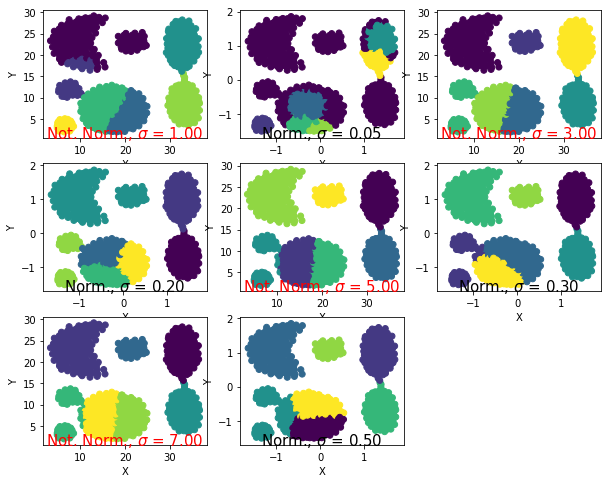

In [27]:
#3b - Plotting few of the results in 3a for the exemplary "Aggregation" dataset.
# we plot here the result for a given initial number of clusters of 7. 
# In the figure, Norm. (Not Norm.) means Normalized (Not Normalized) datasets.
# Sigma is the Kernel variance.

#dataset name
dataset_nm = "Aggregation"
#select a solution for this number of initial clusters
n_clus_sel = 7
#making the plot
plt.figure(num=2,figsize=(10,8))
for i in range(0, 4):
    #getting the dataset: NO normalization
    XX = set_dataframes[dataset_nm].as_matrix(columns=["X","Y"])
    label_loc = KKM_no_norm_labels[dataset_nm][i][0][n_clus_sel]
    #getting the dataset: normalized
    XX_norm = (XX - XX.mean(axis=0))/(XX.std(axis=0)+sys.float_info.epsilon)    
    label_loc_norm = KKM_norm_labels[dataset_nm][i][0][n_clus_sel]
    #plot
    plt.subplot(n_plots, n_plots, 2*i+1) 
    ax = plt.scatter(XX[:,0],XX[:,1],c=label_loc)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], 'Not. Norm., $\sigma$ = %3.2f'%sigma_val_no_norm[i],
             color='red',fontsize=15, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")
    #plot
    plt.subplot(n_plots, n_plots, 2*(i+1)) 
    ax = plt.scatter(XX_norm[:,0],XX_norm[:,1],c=label_loc_norm)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], 'Norm., $\sigma$ = %3.2f'%sigma_val_norm[i],
             fontsize=15, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")

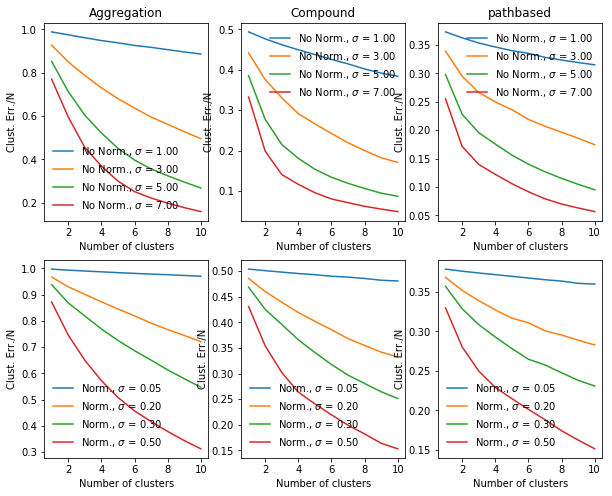

In [32]:
#3c - We now produce an exemplary Elbow plot running over the hyperparameters and
# the 3 selected datasets. We evaluate the clustering error per point in the dataset.

# maximum number of clusters used to produce the elbow plot
n_clusters = len(KKM_norm_labels[dataset_nm][0][0].keys())
    
Elbow_plot_no_norm = {}
Elbow_plot_norm = {}

#gathering data
for nm in dts_names_selected:
    clutser_err_no_norm = np.zeros((len(sigma_val_no_norm),n_clusters))
    clutser_err_norm = np.zeros((len(sigma_val_norm),n_clusters))
    for sgm in range(len(sigma_val_no_norm)):
        for ncl in range(n_clusters):
            clutser_err_no_norm[sgm,ncl] = KKM_no_norm_labels[nm][sgm][1][ncl+1][0]
            clutser_err_norm[sgm,ncl] = KKM_norm_labels[nm][sgm][1][ncl+1][0]
    Elbow_plot_no_norm[nm] = clutser_err_no_norm
    Elbow_plot_norm[nm] = clutser_err_norm
    
#Producing the elbow plot!
dim_subset = len(dts_names_selected)
x_clusters = range(1,1+n_clusters)

plt.figure(num=3,figsize=(10,8))
for i,nm in enumerate(Elbow_plot_no_norm.keys()):
    #get the dataset size
    N_dts = len(set_dataframes[dataset_nm])
    #making the plot
    plt.subplot(2, dim_subset, i+1)
    leg_no_norm = []
    lgd_txt = []
    for sgm in range(len(sigma_val_no_norm)):
        a1, = plt.plot(x_clusters,Elbow_plot_no_norm[nm][sgm,:]/N_dts)
        leg_no_norm.append(a1)
        lgd_txt.append('No Norm., $\sigma$ = %3.2f'%sigma_val_no_norm[sgm])    
    plt.legend(leg_no_norm,lgd_txt,frameon=False)
    plt.xlabel("Number of clusters")
    plt.ylabel("Clust. Err./N")
    plt.title(nm)
    #making the plot
    plt.subplot(2, dim_subset, i+4)
    leg_norm = []
    lgd_txt = []
    for sgm in range(len(sigma_val_norm)):
        a1, = plt.plot(x_clusters,Elbow_plot_norm[nm][sgm,:]/N_dts)
        leg_norm.append(a1)
        lgd_txt.append('Norm., $\sigma$ = %3.2f'%sigma_val_norm[sgm])    
    plt.legend(leg_norm,lgd_txt,frameon=False)
    plt.xlabel("Number of clusters")
    plt.ylabel("Clust. Err./N")

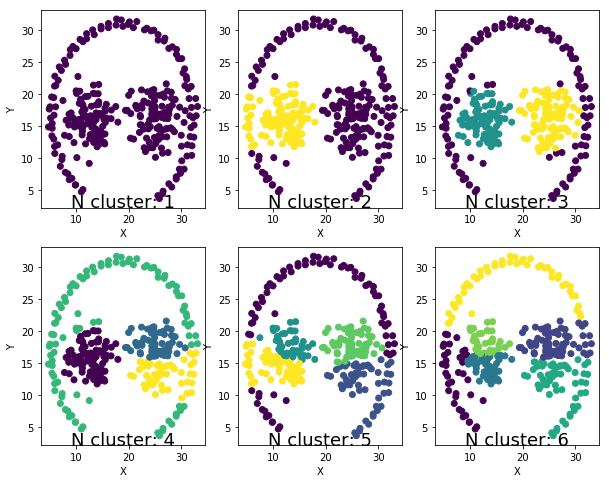

In [33]:
#3d - the above clustering error in the plots are per data point. 
# Interestingly, normalization does not change things dramatically once sigma 
#is rescaled, and will therefore be neglected in our analysis henceforth.

# we would be tempted to say that we do see an elbow in "pathbased" around N=2-3!
#below here we show the clustering results for different initial number of clusters

nm_dts = "pathbased"
XX = set_dataframes[nm_dts].as_matrix(columns=["X","Y"])

plt.figure(num=4,figsize=(10,8))
for i in range(1, 7):
    plt.subplot(2, 3, i) 
    label_loc_norm = KKM_norm_labels[nm_dts][-1][0][i]
    ax = plt.scatter(XX[:,0], XX[:,1], c=label_loc_norm)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], "N cluster: %d"%(i),
             fontsize=18, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")

In [34]:
%%capture
#do not show irrelevant output of the calculation

#4a - Part I- calculation
#In this cell, we perform a full test of the partitional algorithm, in particular:
#        - Kernel k-Means (KKM): 
#            Clusters in feature space.          
#        
#        - Global Kernel k-Means with Convex Mixture Models (GKKM-CMM):
#            optimized boosted version of GkKM to reduce complexity.
#We have chosen these 2 because GKKM-CMM contains the GKKM routine and we can therefore test both 
# at the same time.
# We perform the calculation for all elements of the shape set, for a given Kernel sigma
# and will conclude evaluating the "Normalized mutual information" (NMI) according to the 
# definition given in the Efimov paper.

# selected kernel sigma
sigma_sel = 3

# number of clusters expected in each element of the Shape set
Clusters_set = dict(Aggregation=7,Compound=6,pathbased=3,spiral=3, \
                  D31=31,R15=15,jain=2,flame=2)

#list of partitional algorithms tested
list_algorithms = ["KKM","GKKM-CMM"]

#containing the results
Cluster_partitional = {}

#loop over the algorithms
for nm_algo in list_algorithms:
    Cluster_partitional[nm_algo] = []
    #loop over the elements of the dataset
    for nm_set in Clusters_set.keys():
        # loading data
        XX = set_dataframes[nm_set].as_matrix(columns=["X","Y"])
        # number of expected clusters
        n_clust_loc = Clusters_set[nm_set]
        # initialization of the class
        class_no_norm = cl.Cluster_class(algorithm=nm_algo,verbose=0, \
                                          n_clusters=n_clust_loc,sigm_gauss=sigma_sel)
        #starting the clustering
        class_no_norm.fit(XX)
        #save results
        Cluster_partitional[nm_algo].append([class_no_norm.labels_,class_no_norm.cluster_error_])

100% (14 of 14) |################################################################################################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (14 of 14) |################################################################################################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (14 of 14) |################################################################################################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (14 of 14) |################################################################################################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (14 of 14) |################################################################################################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (14 of 14) |################################################################################################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (12 of 12) |#############################################################################

100% (30 of 30) |################################################################################################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (30 of 30) |################################################################################################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (30 of 30) |################################################################################################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (30 of 30) |################################################################################################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (30 of 30) |################################################################################################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (4 of 4) |##################################################################################################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (4 of 4) |###############################################################################

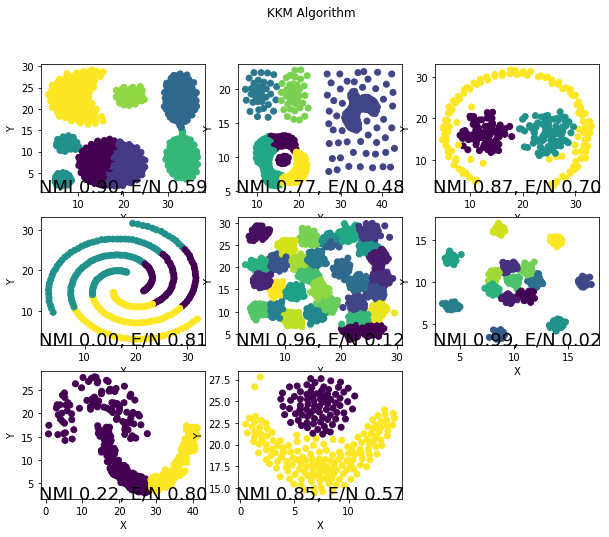

In [102]:
#4b - Part II- plotting the KKM results
# we plot here the results of section 4a- Part I
# NMI is the "Normalized mutual information"
# E/N is the clustering error per point

#plot for the KKM algorithm first
algo_sel = 0
#dataset names
dts_name = list(Clusters_set.keys())

#making the plot
plt.figure(num=1,figsize=(10,8))
for i in range(1, n_plots**2):
    #loading results
    algo_name = list_algorithms[algo_sel]
    # predicted labels
    predicted_labels = Cluster_partitional[algo_name][i-1][0][Clusters_set[dts_name[i-1]]]
    #get the dataset size
    N_dts = len(set_dataframes[dts_name[i-1]])
    #get the normalized error
    Normalized_error = Cluster_partitional[algo_name][i-1][1][Clusters_set[dts_name[i-1]]][0]/N_dts
    #calculate the NMI
    NMI_loc = NMI(set_dataframes[dts_name[i-1]].as_matrix(columns=["Labels"]).reshape(-1,),predicted_labels.reshape(-1,))
    #plotting
    plt.subplot(n_plots, n_plots, i) 
    ax = plt.scatter(set_dataframes[dts_name[i-1]]["X"], \
                 set_dataframes[dts_name[i-1]]["Y"], \
                 c=predicted_labels)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], "NMI %3.2f, E/N %3.2f"%(NMI_loc,Normalized_error),
             fontsize=18, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")
plt.suptitle("%s Algorithm"%algo_name)

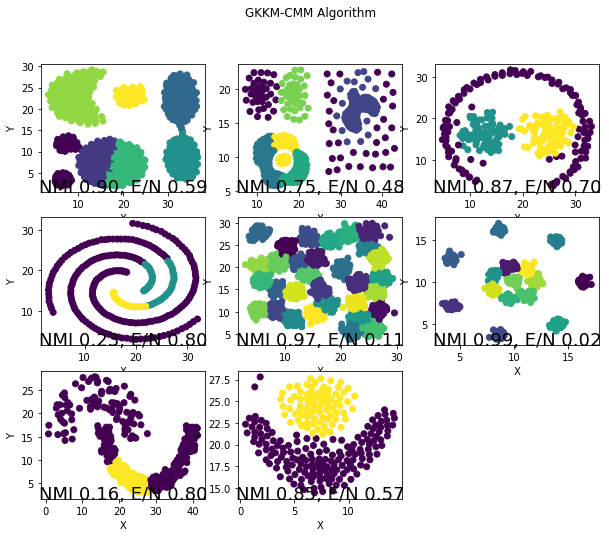

In [103]:
#4c - Part II- plotting the GKKM-CMM results
# we plot here the results of section 4a- Part I
# NMI is the "Normalized mutual information"
# E/N is the clustering error per point

#plot for the GKKM-CMM algorithm first
algo_sel = 1
#dataset names
dts_name = list(Clusters_set.keys())

#making the plot
plt.figure(num=1,figsize=(10,8))
for i in range(1, n_plots**2):
    #loading results
    algo_name = list_algorithms[algo_sel]
    # predicted labels
    predicted_labels = Cluster_partitional[algo_name][i-1][0][Clusters_set[dts_name[i-1]]]
    #get the dataset size
    N_dts = len(set_dataframes[dts_name[i-1]])
    #get the normalized error
    Normalized_error = Cluster_partitional[algo_name][i-1][1][Clusters_set[dts_name[i-1]]][0]/N_dts
    #calculate the NMI
    NMI_loc = NMI(set_dataframes[dts_name[i-1]].as_matrix(columns=["Labels"]).reshape(-1,),predicted_labels.reshape(-1,))
    #plotting
    plt.subplot(n_plots, n_plots, i) 
    ax = plt.scatter(set_dataframes[dts_name[i-1]]["X"], \
                 set_dataframes[dts_name[i-1]]["Y"], \
                 c=predicted_labels)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], "NMI %3.2f, E/N %3.2f"%(NMI_loc,Normalized_error),
             fontsize=18, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")
plt.suptitle("%s Algorithm"%algo_name)

In [15]:
%%capture
#do not show irrelevant output of the calculation

#5a - In this section we want to test the Adaptive Weights Clustering (AWC) algorithm
# the algorithm is allegedly capable of recognizing the number of clusters within a dataset up
# to a parameter lambda. Lambda should be selected via, e.g., a procedure called "sum of weights heuristic".
# I did not have time to implement such routine, so below here I compute the AWC on the Shape set 
# by heuristically fixing values of lambda.

#values of lambda
list_lambda = [5,10,5,5/2,5,4.5,4,3]

#storing results
Cluster_prop_sep = {}
#loop over the elements in the dataset
for i,nm_set in enumerate(Clusters_set.keys()):
    # list for the present element in the dataset
    Cluster_prop_sep[nm_set]=[]
    #loading data
    XX = set_dataframes[nm_set].as_matrix(columns=["X","Y"])
    #initializing class
    class_no_norm = cl.Cluster_class(algorithm="AWC",verbose=0,lambda_=list_lambda[i])
    #performing clustering
    class_no_norm.fit(XX)
    #save results
    Cluster_prop_sep[nm_set].append(class_no_norm.labels_)

100% (12 of 12) |################################################################################################| Elapsed Time: 0:00:06 Time: 0:00:06
100% (14 of 14) |################################################################################################| Elapsed Time: 0:00:02 Time: 0:00:02
100% (12 of 12) |################################################################################################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (12 of 12) |################################################################################################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (17 of 17) |################################################################################################| Elapsed Time: 0:03:51 Time: 0:03:51
100% (16 of 16) |################################################################################################| Elapsed Time: 0:00:06 Time: 0:00:06
100% (12 of 12) |#############################################################################

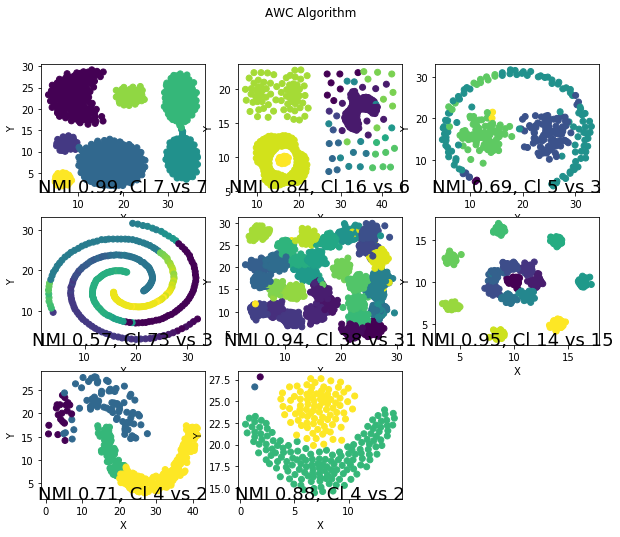

In [16]:
#5b- We plot the results of the AWC algorithm, as computed in section 5a.
# each plot shows the NMI value and the number of predicted clusters vs the real ones
# we clearly see that:
# - results are very good for the Aggregation set
# - the major section of the Compound plot are grasped with this lambda, but too many
# clusters come up in the region to the right, where many disconnected points are present
# - results are quite good for most set, except the spiral one

elm = list(Clusters_set.keys())
#making the plot
plt.figure(num=5,figsize=(10,8))
for sel in range(len(elm)):
    #loading dataset
    XX = set_dataframes[elm[sel]].as_matrix(columns=["X","Y"])
    #getting predicted number of clusters
    N_id_cl = list(Cluster_prop_sep[elm[sel]][0].keys())
    #getting predicted labels
    lab = Cluster_prop_sep[elm[sel]][0][N_id_cl[0]]
    #getting expected labels
    elab = set_dataframes[elm[sel]].as_matrix(columns=["Labels"])    
    #calculate the NMI
    NMI_loc = NMI(elab.reshape(-1,),lab.reshape(-1,))    
    #plotting
    plt.subplot(n_plots, n_plots, sel+1) 
    ax = plt.scatter(XX[:,0],XX[:,1], c=lab)
    loc_ax = np.array(plt.axis())
    plt.text(np.mean(loc_ax[:2]),loc_ax[2], "NMI %3.2f, Cl %d vs %d"%(NMI_loc,N_id_cl[0],Clusters_set[elm[sel]]),
             fontsize=18, ha='center')    
    plt.xlabel("X")
    plt.ylabel("Y")
plt.suptitle("AWC Algorithm")